# Creating xGoals
##### This notebook is a derivative of the following notebook:
https://www.kaggle.com/code/gabrielmanfredi/expected-goals-player-analysis/notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime as dt
from zipfile import ZipFile

# Set Up:
### Load Data
### Combine Datasets
### Isolate shots

In [2]:
events = pd.read_csv('/Users/reececalvin/Sports Analytics Club/Soccer/soccer events/events.csv')
info = pd.read_csv('/Users/reececalvin/Sports Analytics Club/Soccer/soccer events/ginf.csv')

In [9]:
zip_file_path = 'soccer events.zip'
csv_file_names = ['soccer events/events.csv', 'soccer events/ginf.csv']
    
# List to hold dataframes
dfs = []

# Open the ZIP file and read each CSV into a pandas DataFrame\n",
with ZipFile(zip_file_path, 'r') as z:
    for csv_file_name in csv_file_names:
        with z.open(csv_file_name) as f:
            dfs.append(pd.read_csv(f))
# Define the DataFrames\n",
events = dfs[0]
info = dfs[1]

In [10]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [11]:
extract_year = lambda x: dt.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [12]:
shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_60583/4185971030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player'] = shots['player'].str.title()
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_60583/4185971030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player2'] = shots['player2'].str.title()
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_60583/4185971030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

# Data Exploration

### Plot Shot Outcomes

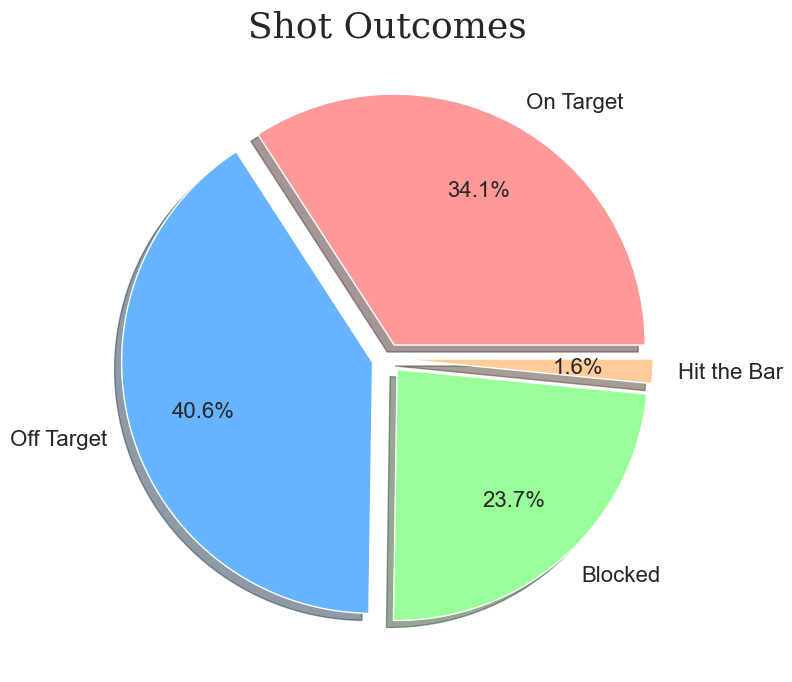

In [13]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

### Group shots by placement and plot frequency

In [14]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
bar.shot_place = bar.shot_place.astype(int)
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

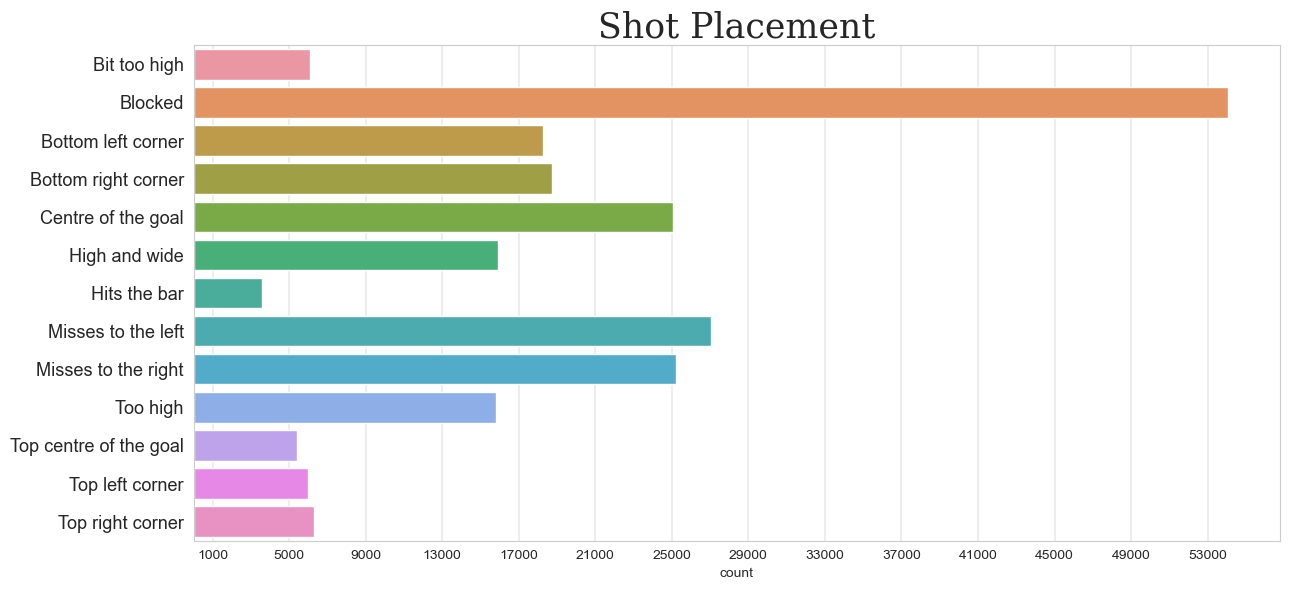

In [15]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## xGoals

## Needed info:
1) Location: attacking half, defensive half, centre of the box, left wing, right wing, difficult angle and long range, difficult angle on the left, difficult angle on the right, left side of the box, left side of the six yard box, right side of the box, right side of the six yard box, very close range, penalty spot, outside the box, long range, more than 35 yards, more than 40 yards, not recorded
2) Bodypart: right foot, left foot, head
3) Assist_method: none, pass, cross, headed pass, through ball
4) Situation: open play, set piece, corner, free kick
5) Fast_break: 1 or 0, whether the shot comes from a fast break or not

In [16]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

In [17]:
# Drop shots from without a location
data = data[data['not_recorded'] == 0]

In [18]:
data.head()

,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,...,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick,is_goal
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
13,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
14,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [19]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def evaluate_model(params): 
    model = XGBClassifier(
                        learning_rate=params['learning_rate'],
                        max_depth=params['max_depth'],
                        n_estimators=params['n_estimators'],
                        )
    
    # Perform 5-fold cross-validation
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    avg_roc_auc = roc_auc_scores.mean()

    return {
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'n_estimators': params['n_estimators'],
        'avg_ROCAUC': avg_roc_auc
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['avg_ROCAUC']  # Minimize negative ROC AUC
    res['status'] = STATUS_OK
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'n_estimators': hp.choice('n_estimators', range(100, 500)),
}


trials = Trials()
best = fmin(fn=objective,
            space=hyperparameter_space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

best['max_depth'] = best['max_depth'] + 2
best['n_estimators'] = best['n_estimators'] + 100

 20%|██        | 2/10 [05:47<22:11, 166.39s/trial, best loss: -0.8052112743551693]

In [ ]:
best

In [ ]:
pd.DataFrame(trials.results).sort_values(by='loss', ascending=False).head(10)

In [ ]:
xgb_model = XGBClassifier(**best)
xgb_model.fit(X_train, y_train)

xgb_model.score(X_test, y_test)

In [ ]:
y_pred = xgb_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
sns.heatmap(cm_perc, annot=True, fmt='.2f', cmap="Blues")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

![Precision Formula](https://miro.medium.com/max/1280/1*qkqoZmhxO4s0fG75xEiRkA.jpeg "Precision Formula")
![Recall Formula](https://miro.medium.com/max/1232/1*BiB0AmdCN_O5Gi8d6j2ixg.png "Recall Formula")
![F1 Score Formula](https://miro.medium.com/max/1104/1*FL6nadrpcxBmFV5YVbp76w.png "F1 Score Formula")


## Logistic Regression

![Logistic Regression](https://miro.medium.com/max/932/1*bCCcQhMjHGaI89i-7i3xFw.png "Logistic Regression")

In [ ]:
log_model = LogisticRegression(max_iter=400)
log_model.fit(X_train, y_train)
log_model.score(X_test, y_test)

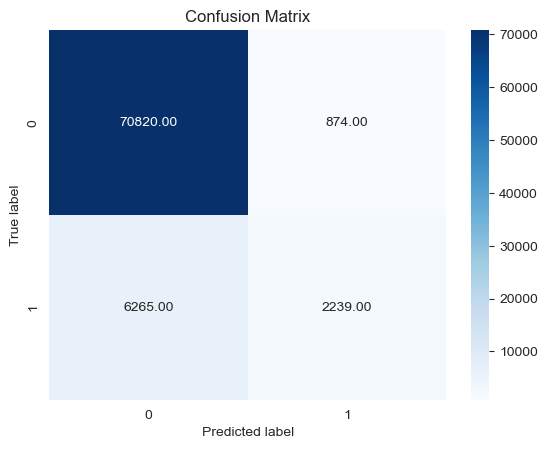

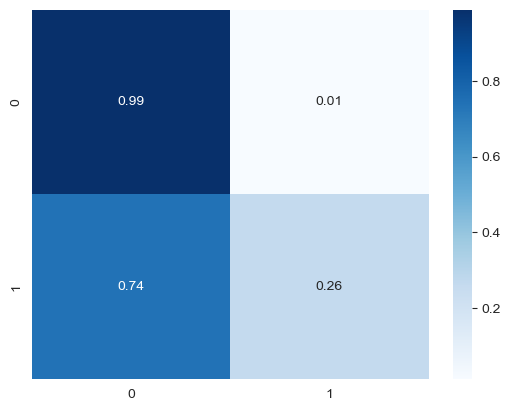

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198


In [18]:
y_pred = log_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
sns.heatmap(cm_perc, annot=True, fmt='.2f', cmap="Blues")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

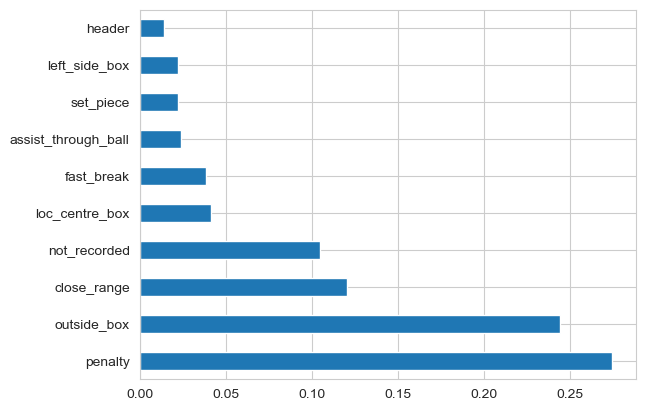

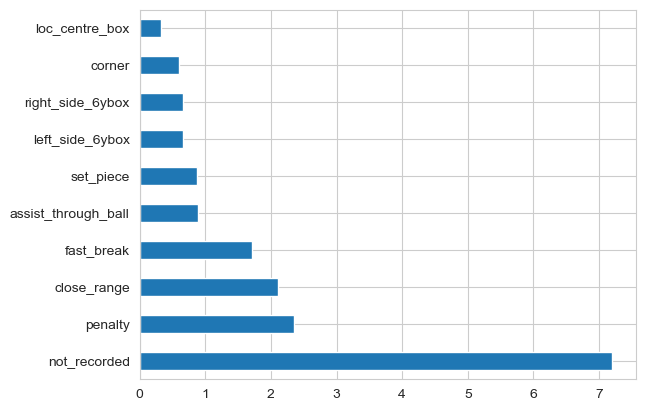

In [22]:
# Plot feat importances

# xgb model
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# log model
feat_importances = pd.Series(log_model.coef_[0], index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()